# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [27]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.serialization import load_lua
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd
# from models import build_ssd as build_ssd_v1 # uncomment for older pool6 model

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [28]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('../weights/ssd300_0712_0.pth')

/Users/zhpmatrix/Desktop/webcam/ssd.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


Loading weights into state dict...
Finished!


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

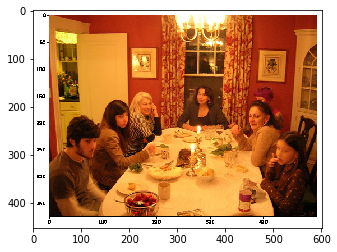

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOCroot, AnnotationTransform


# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
#testset = VOCDetection(VOCroot, [('2007', 'val')], None, AnnotationTransform())
#img_id = 60
#image = testset.pull_image(img_id)
#rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
#plt.figure(figsize=(10,10))
#plt.imshow(rgb_image)


# Load single example picture
image = cv2.imread('../data/example_crowd.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
(r,g,b)=cv2.split(image)
image = cv2.merge([b,g,r])
plt.imshow(image)
plt.show()
rgb_image = image

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

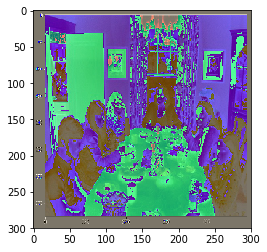

In [32]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [33]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

/Users/zhpmatrix/Desktop/webcam/ssd.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.softmax(conf.view(-1, self.num_classes)),  # conf preds


## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/tensor.py:318: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)


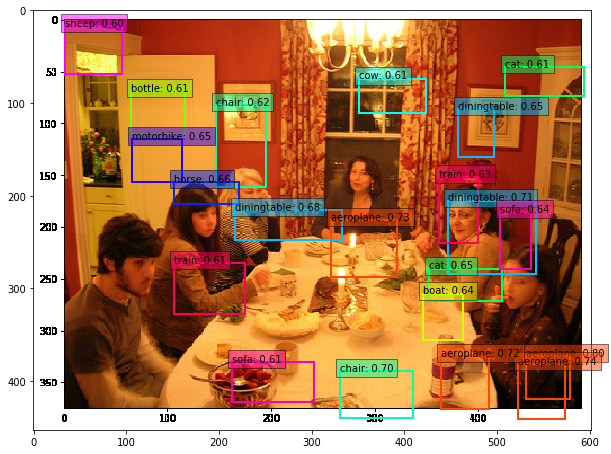

In [34]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor([rgb_image.shape[1::-1], rgb_image.shape[1::-1]])
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1